In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision  import models,transforms,datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'2.1.0+cu121'

In [3]:
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [5]:
%mkdir data
%cd /content/data
!wget http://files.fast.ai/data/examples/dogscats.tgz

/content/data
--2024-02-13 15:21:01--  http://files.fast.ai/data/examples/dogscats.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 104.26.2.19, 172.67.69.159, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/dogscats.tgz [following]
--2024-02-13 15:21:01--  https://files.fast.ai/data/examples/dogscats.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839285364 (800M) [application/x-gtar-compressed]
Saving to: ‘dogscats.tgz’

dogscats.tgz        100%[===================>] 800.40M  57.1MB/s    in 9.1s    

2024-02-13 15:21:10 (88.4 MB/s) - ‘dogscats.tgz’ saved [839285364/839285364]



In [6]:
!tar -zxvf dogscats.tgz;

Streaming output truncated to the last 5000 lines.
dogscats/test1/4634.jpg
dogscats/test1/5841.jpg
dogscats/test1/4590.jpg
dogscats/test1/7251.jpg
dogscats/test1/1014.jpg
dogscats/test1/3899.jpg
dogscats/test1/8220.jpg
dogscats/test1/11600.jpg
dogscats/test1/1223.jpg
dogscats/test1/786.jpg
dogscats/test1/8842.jpg
dogscats/test1/7416.jpg
dogscats/test1/3641.jpg
dogscats/test1/9389.jpg
dogscats/test1/4093.jpg
dogscats/test1/883.jpg
dogscats/test1/5787.jpg
dogscats/test1/12059.jpg
dogscats/test1/10965.jpg
dogscats/test1/7406.jpg
dogscats/test1/5904.jpg
dogscats/test1/9852.jpg
dogscats/test1/5532.jpg
dogscats/test1/7344.jpg
dogscats/test1/1327.jpg
dogscats/test1/2836.jpg
dogscats/test1/6135.jpg
dogscats/test1/1938.jpg
dogscats/test1/6757.jpg
dogscats/test1/4972.jpg
dogscats/test1/8333.jpg
dogscats/test1/990.jpg
dogscats/test1/1936.jpg
dogscats/test1/3790.jpg
dogscats/test1/7500.jpg
dogscats/test1/1473.jpg
dogscats/test1/459.jpg
dogscats/test1/5137.jpg
dogscats/test1/4541.jpg
dogscats/test1

In [7]:
%ls

dogscats/  dogscats.tgz


In [8]:
%cd dogscats/
%ls

/content/data/dogscats
sample/  test1/  train/  valid/


In [9]:
%cd ..

/content/data


In [10]:
data_dir = '/content/data/dogscats'

In [11]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
imagenet_format = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [12]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir,x),imagenet_format)
  for x in ['train','valid']}

In [13]:
??datasets.ImageFolder

In [14]:
os.path.join(data_dir,'train')

'/content/data/dogscats/train'

In [15]:
?datasets.ImageFolder

In [16]:
dsets['train'].classes

['cats', 'dogs']

In [17]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

In [18]:
dsets['train'].imgs[:5]

[('/content/data/dogscats/train/cats/cat.0.jpg', 0),
 ('/content/data/dogscats/train/cats/cat.1.jpg', 0),
 ('/content/data/dogscats/train/cats/cat.10.jpg', 0),
 ('/content/data/dogscats/train/cats/cat.100.jpg', 0),
 ('/content/data/dogscats/train/cats/cat.1000.jpg', 0)]

In [19]:
dsets_sizes = {x:len(dsets[x]) for x in ['train','valid']}
dsets_sizes

{'train': 23000, 'valid': 2000}

In [20]:
dset_classes = dsets['train'].classes


In [21]:
?imagenet_format

In [22]:
loader_train = torch.utils.data.DataLoader(dsets['train'],batch_size=64,shuffle=True,num_workers=6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
?torch.utils.data.DataLoader

In [24]:
loader_valid = torch.utils.data.DataLoader(dsets['valid'],batch_size=5,shuffle=False,num_workers=6)

In [25]:
count = len(loader_valid)
inputs_try,labels_try = next(iter(loader_valid))

In [26]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

In [27]:
def imshow(inp,title=None):
  inp = inp.numpy().transpose(1,2,0)
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = np.clip(std*inp + mean,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)


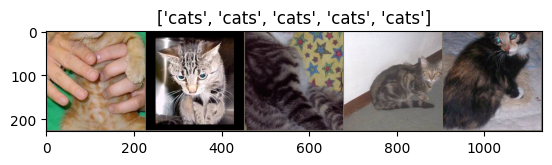

In [28]:
out = torchvision.utils.make_grid(inputs_try)
imshow(out,title=[dset_classes[x] for x in labels_try])

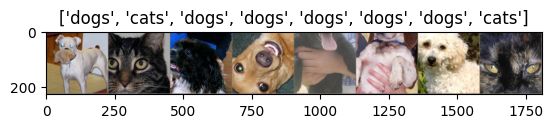

In [29]:
inputs,classes = next(iter(loader_train))
n_images = 8
out = torchvision.utils.make_grid(inputs[:n_images])
imshow(out,title=[dset_classes[x] for x in classes[:n_images]])

In [30]:
model_vgg = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.6MB/s]


In [31]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-02-13 15:21:36--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.106.32, 52.217.124.200, 52.216.216.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.106.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2024-02-13 15:21:36 (558 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [32]:
import json

fpath = '/content/data/imagenet_class_index.json'
with open(fpath) as f:
  class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]


In [33]:
dic_imagenet[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

In [34]:
inputs_try, labels_try = inputs_try.to(device), labels_try.to(device)
model_vgg = model_vgg.to(device)

In [35]:
outputs_try = model_vgg(inputs_try)

In [36]:
outputs_try

tensor([[ 1.3395,  0.1747,  0.2458,  ...,  3.7668,  2.8360, -0.0345],
        [-1.6941,  2.0101, -4.1058,  ..., -5.2945,  7.6738,  4.0713],
        [-1.3334, -1.3425, -1.1346,  ..., -2.5701,  0.5004,  3.3766],
        [-2.3862, -2.3374,  0.5643,  ..., -6.0817,  0.2016,  3.7811],
        [-4.1970, -2.9180, -3.0376,  ..., -3.9741,  1.3377,  3.2001]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
outputs_try.shape

torch.Size([5, 1000])

In [38]:
m_softm = nn.Softmax(dim = 1)
probs = m_softm(outputs_try)
val_try, preds_try = torch.max(probs,dim=1)

In [39]:
val_try,preds_try

(tensor([0.1428, 0.8818, 0.5913, 0.8949, 0.3983], device='cuda:0',
        grad_fn=<MaxBackward0>),
 tensor([219, 281, 281, 281, 359], device='cuda:0'))

In [40]:
torch.sum(probs,1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

In [41]:
print([dic_imagenet[i] for i in preds_try.data])

['cocker_spaniel', 'tabby', 'tabby', 'tabby', 'black-footed_ferret']


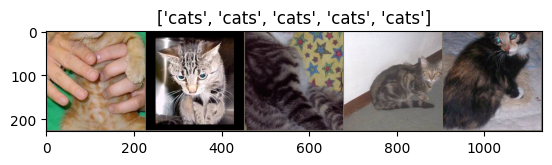

In [42]:
out =  torchvision.utils.make_grid(inputs_try.data.cpu())
imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

In [43]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
for param in model_vgg.parameters():
  param.requires_grad = False

model_vgg.classifier._modules['6'] = nn.Linear(4096,2)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [45]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)


In [46]:
model_vgg = model_vgg.to(device)

In [47]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

In [48]:
def train_model(model,dataloader,size, epochs=1,optimizer = None):
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
      inputs = inputs.to(device)
      classes = classes.to(device)
      outputs = model(inputs)
      loss = criterion(outputs,classes)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      _,preds = torch.max(outputs.data,1)
      # Stats
      running_loss +=loss.data.item()
      running_corrects += torch.sum(preds == classes.data)
    epoch_loss = running_loss/ size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:4f}'.format(epoch_loss,epoch_acc))

In [49]:
%%time
train_model(model_vgg,loader_train,size=dsets_sizes['train'],epochs =4,optimizer=optimizer_vgg)

Loss: 0.0023 Acc: 0.953913
Loss: 0.0013 Acc: 0.971609
Loss: 0.0012 Acc: 0.972130
Loss: 0.0011 Acc: 0.974870
CPU times: user 5min 39s, sys: 23.6 s, total: 6min 2s
Wall time: 8min 17s


In [50]:
def test_model(model,dataloader,size):
  model.eval()
  predictions = np.zeros(size)
  all_classes = np.zeros(size)
  all_proba = np.zeros((size,2))
  i = 0
  running_loss = 0.0
  running_corrects = 0
  for inputs,classes in dataloader:
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs = model(inputs)
    loss = criterion(outputs,classes)
    _,preds = torch.max(outputs.data,1)
    #stats
    running_loss += loss.data.item()
    running_corrects += torch.sum(preds == classes.data)
    predictions[i:i+len(classes)] = preds.to('cpu').numpy()
    all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
    i += len(classes)
  epoch_loss = running_loss / size
  epoch_acc = running_corrects.data.item() / size
  print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc))
  return predictions,all_proba,all_classes

In [51]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size = dsets_sizes['valid'])

Loss: 0.0101 Acc: 0.9825


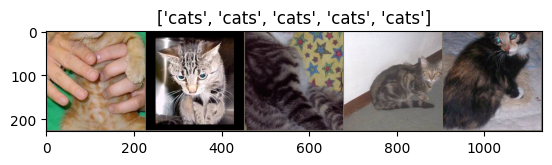

In [52]:
inputs, classes = next(iter(loader_valid))
out = torchvision.utils.make_grid(inputs[:n_images])
imshow(out,title=[dset_classes[x] for x in classes[:n_images]])

In [53]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

In [54]:
x_try = model_vgg.features(inputs_try)

In [55]:
x_try.shape

torch.Size([5, 512, 7, 7])

In [56]:
def preconvfeat(dataloader):
  conv_features = []
  labels_list = []
  for data in dataloader:
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    x = model_vgg.features(inputs)
    conv_features.extend(x.data.cpu().numpy())
    labels_list.extend(labels.data.cpu().numpy())

  conv_features = np.concatenate([[feat] for feat in conv_features])
  return (conv_features,labels_list)


In [57]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 1min 31s, sys: 10.4 s, total: 1min 41s
Wall time: 2min 7s


In [58]:
conv_feat_train.shape

(23000, 512, 7, 7)

In [59]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 10.7 s, sys: 1.36 s, total: 12 s
Wall time: 17.8 s


In [60]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

In [61]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dsets_sizes['train'],epochs=50,optimizer = optimizer_vgg)

Loss: 0.0005 Acc: 0.974826
Loss: 0.0005 Acc: 0.975217
Loss: 0.0005 Acc: 0.976391
Loss: 0.0005 Acc: 0.975609
Loss: 0.0005 Acc: 0.975826
Loss: 0.0005 Acc: 0.977609
Loss: 0.0005 Acc: 0.976609
Loss: 0.0005 Acc: 0.977174
Loss: 0.0005 Acc: 0.977522
Loss: 0.0005 Acc: 0.975739
Loss: 0.0005 Acc: 0.977652
Loss: 0.0004 Acc: 0.978435
Loss: 0.0005 Acc: 0.977652
Loss: 0.0005 Acc: 0.977130
Loss: 0.0005 Acc: 0.977391
Loss: 0.0004 Acc: 0.977609
Loss: 0.0004 Acc: 0.977826
Loss: 0.0004 Acc: 0.977478
Loss: 0.0004 Acc: 0.978870
Loss: 0.0004 Acc: 0.978000
Loss: 0.0004 Acc: 0.978652
Loss: 0.0004 Acc: 0.978174
Loss: 0.0004 Acc: 0.978826
Loss: 0.0004 Acc: 0.979391
Loss: 0.0004 Acc: 0.978478
Loss: 0.0004 Acc: 0.980174
Loss: 0.0004 Acc: 0.978478
Loss: 0.0004 Acc: 0.978609
Loss: 0.0004 Acc: 0.979000
Loss: 0.0004 Acc: 0.979391
Loss: 0.0004 Acc: 0.978783
Loss: 0.0004 Acc: 0.979565
Loss: 0.0004 Acc: 0.980217
Loss: 0.0004 Acc: 0.978261
Loss: 0.0004 Acc: 0.979130
Loss: 0.0004 Acc: 0.979348
Loss: 0.0004 Acc: 0.979870
L

In [62]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [63]:
predictions,all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dsets_sizes['valid'])

Loss: 0.0003 Acc: 0.9855
